In [2]:
%matplotlib inline

In [3]:
from Functions import *

## Data Exploration

In [4]:
data = load_data()

### What does the data look like?

In [5]:
data.shape

(146, 22)

In [6]:
data.columns

Index(['bonus', 'deferral_payments', 'deferred_income', 'director_fees',
       'email_address', 'exercised_stock_options', 'expenses', 'from_messages',
       'from_poi_to_this_person', 'from_this_person_to_poi', 'loan_advances',
       'long_term_incentive', 'name', 'other', 'poi', 'restricted_stock',
       'restricted_stock_deferred', 'salary', 'shared_receipt_with_poi',
       'to_messages', 'total_payments', 'total_stock_value'],
      dtype='object')

I'm working with a relatively small dataset with only 146 observations and 19 features (excluding email address, poi, and name).

How many POI vs non-POI data points are there?

In [7]:
data.poi.value_counts()

False    128
True      18
Name: poi, dtype: int64

The data is also very unbalanced with only 18 of the 146 observations being poi's. Later when fitting my classifier, I used a resampling method to help deal with this. 

In [8]:
data.count()

bonus                         82
deferral_payments             39
deferred_income               49
director_fees                 17
email_address                111
exercised_stock_options      102
expenses                      95
from_messages                 86
from_poi_to_this_person       86
from_this_person_to_poi       86
loan_advances                  4
long_term_incentive           66
name                         146
other                         93
poi                          146
restricted_stock             110
restricted_stock_deferred     18
salary                        95
shared_receipt_with_poi       86
to_messages                   86
total_payments               125
total_stock_value            126
dtype: int64

All of my features have a least some missing values, with a couple (eg loan_advances) hardly ever being filled. Most algorithms can't handle null feature values, so when fitting the classifier I need to impute a new value for these. 

### Looking for Outliers

In [9]:
financial_features = ['salary', 
                      'deferral_payments', 
                      'total_payments',
                      'loan_advances',
                      'bonus',
                      'restricted_stock_deferred',
                      'deferred_income', 
                      'total_stock_value',
                      'expenses',
                      'exercised_stock_options',
                      'other',
                      'long_term_incentive',
                      'restricted_stock',
                      'director_fees'] 

email_features = ['to_messages', 
#                  'email_address', 
                 'from_poi_to_this_person', 
                 'from_messages', 
                 'from_this_person_to_poi', 
                 'shared_receipt_with_poi'] 

all_features = financial_features + email_features

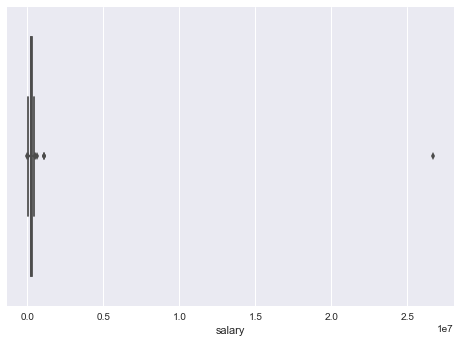

In [10]:
for feat in financial_features:
    sns.boxplot(data[feat])
    plt.show()
    break

I cut this loop earlier because there is one data point with waay too large of values and showing all the graphs seemed silly. This outlying point in the salary boxplot above is the 'Total' observation which I assume is all the employees together. 

In [11]:
data[data.salary == data.salary.max()]['name']

138    Total
Name: name, dtype: object

I'll remove that observation and continue:

In [12]:
data = data[data.name != 'Total']

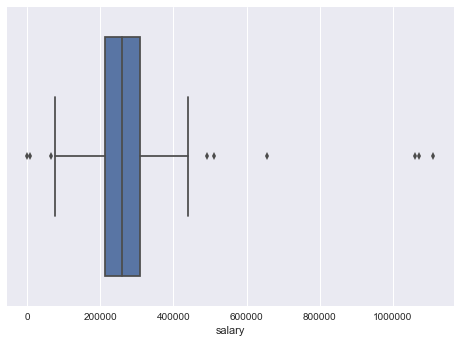

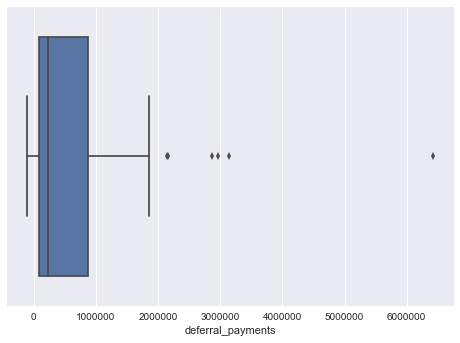

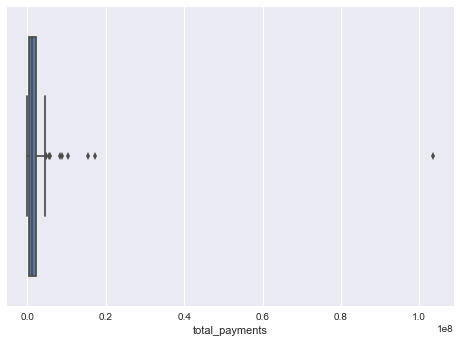

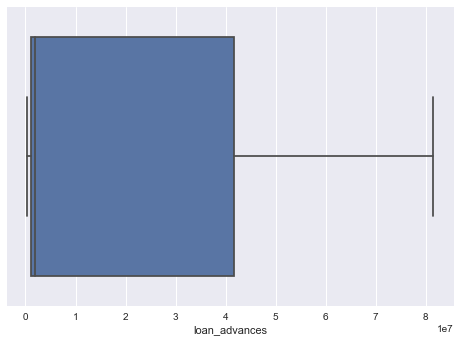

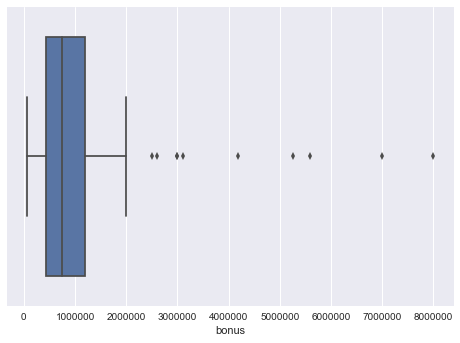

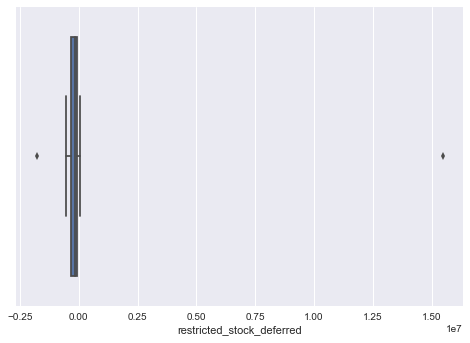

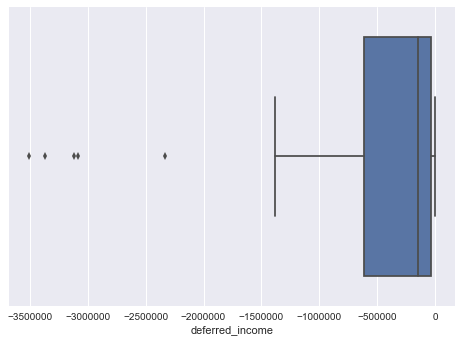

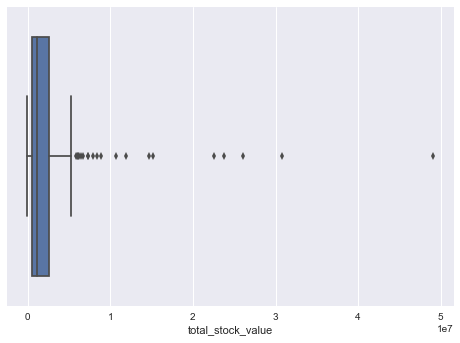

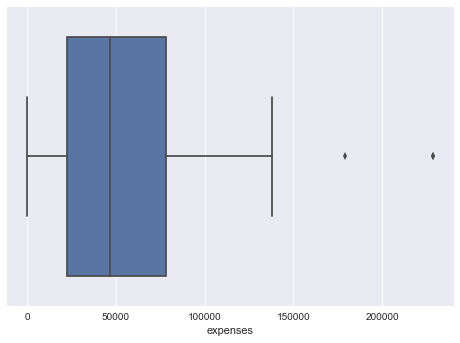

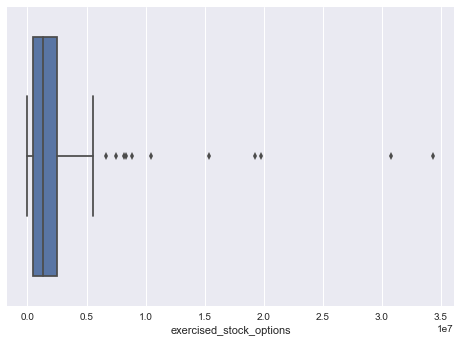

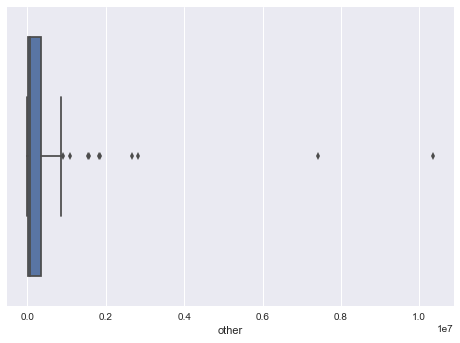

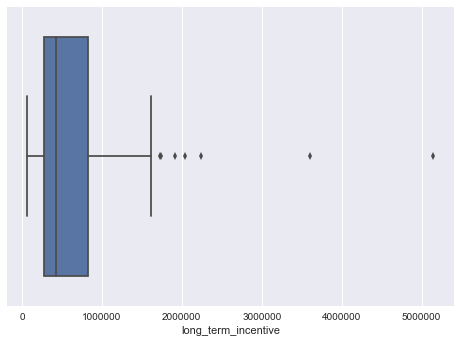

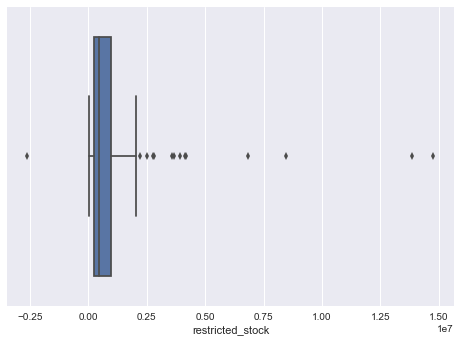

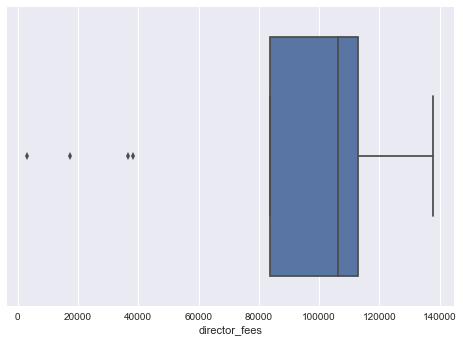

In [13]:
for feat in financial_features:
    sns.boxplot(data[feat])
    plt.show()

A couple of these points appear out of control. What is that total payments in the tens of millions?

In [14]:
data[data.total_payments == data.total_payments.max()][['name', 'poi']]

,name,poi
136,Lay Kenneth L,True


Ah, Kenneth Lay was the chairman of Enron. We definitely want to keep him in the final analysis, but I'll throw him out for these visuals. 

In [15]:
sub_data = data[data.index != 53]

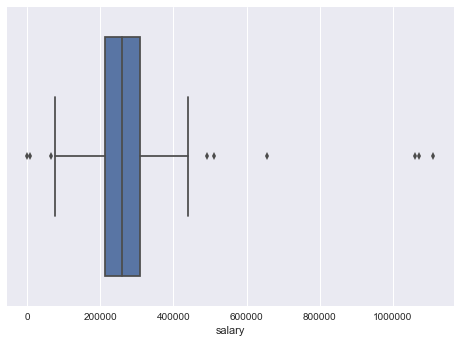

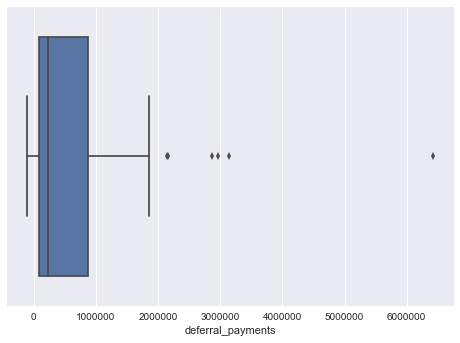

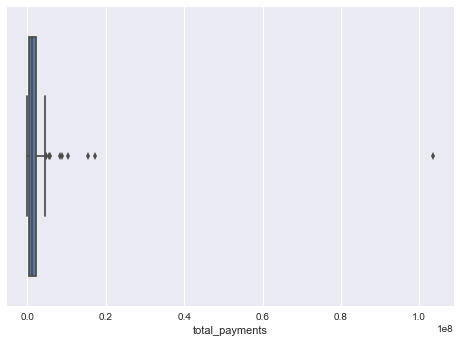

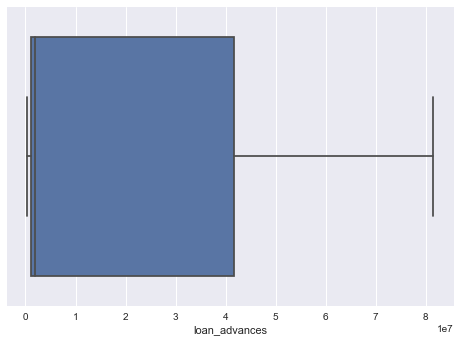

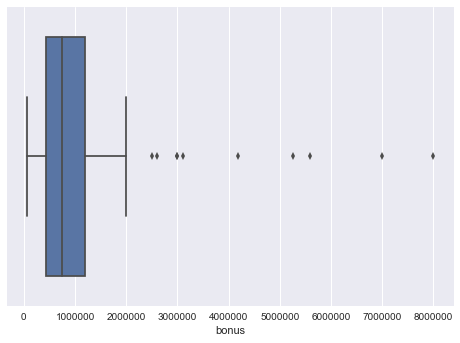

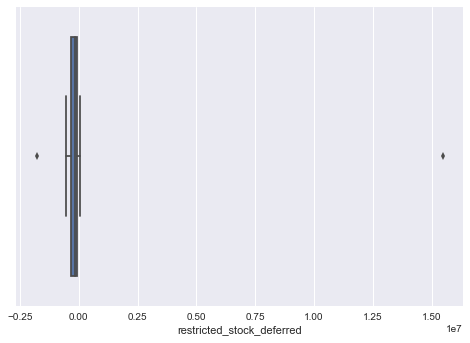

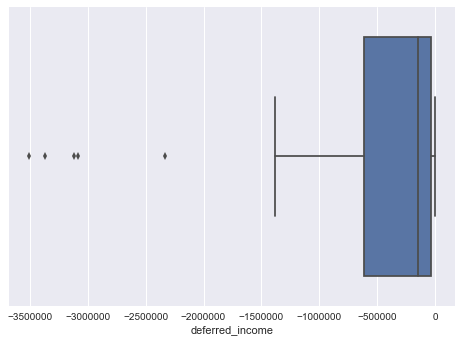

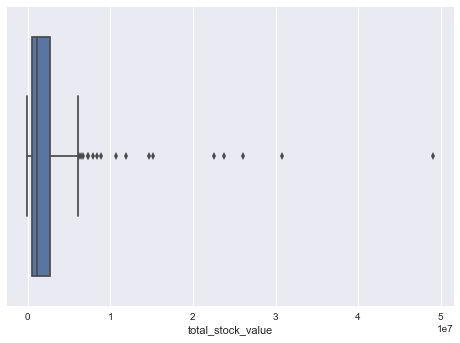

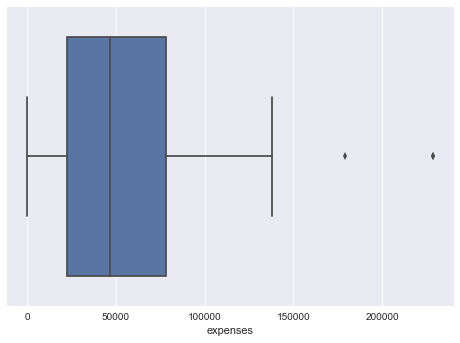

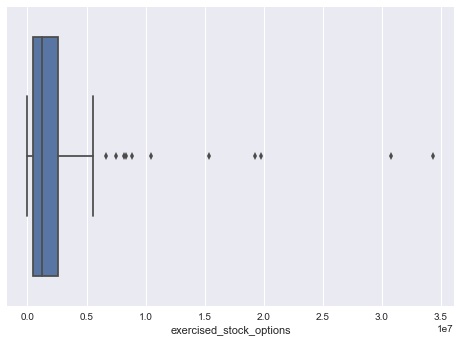

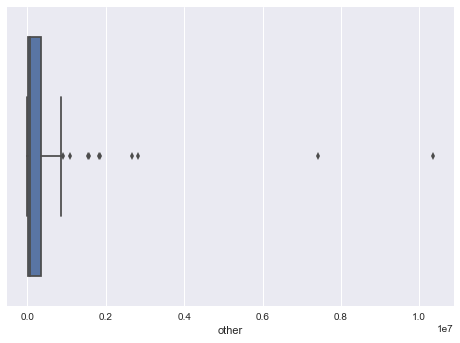

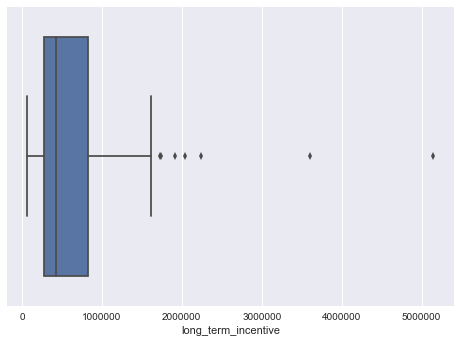

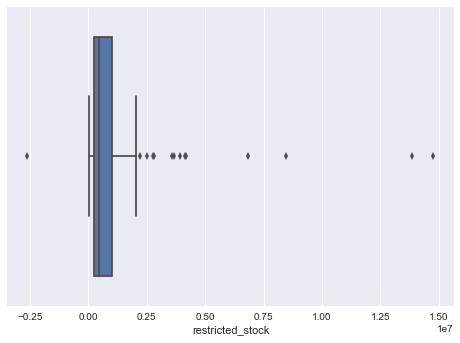

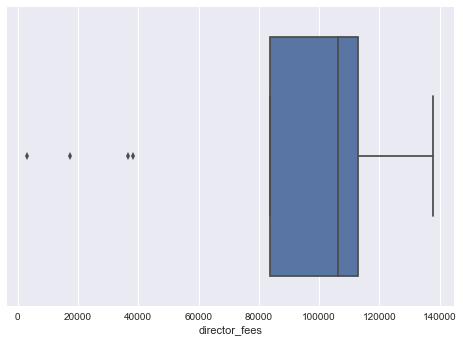

In [16]:
for feat in financial_features:
    sns.boxplot(sub_data[feat])
    plt.show()

In [17]:
data.ix[sub_data.restricted_stock.idxmax(), ['name', 'poi']]

name    Lay Kenneth L
poi              True
Name: 136, dtype: object

In [18]:
data.ix[sub_data.other.idxmax(), ['name', 'poi']]

name    Lay Kenneth L
poi              True
Name: 136, dtype: object

In [19]:
data.ix[sub_data.expenses.idxmax(), ['name', 'poi']]

name    Mcclellan George
poi                False
Name: 128, dtype: object

There's a couple large outlying points still, but after Googling a couple of these names, they appear to be typical high-ranking Enron employees. I'll keep the remaining points. 

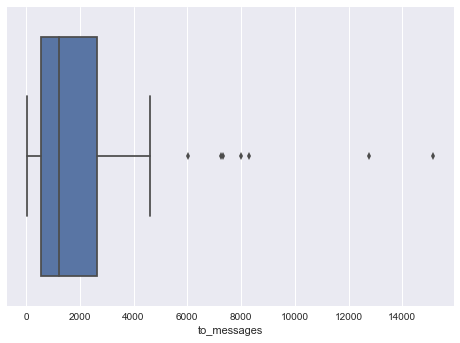

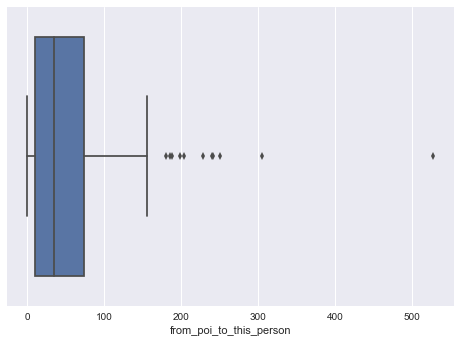

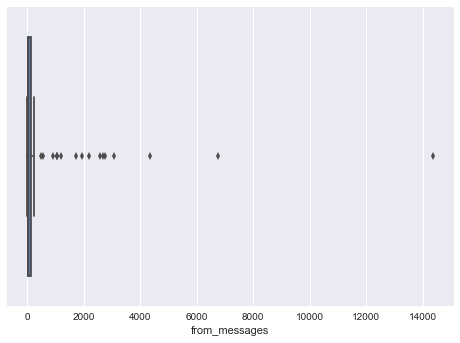

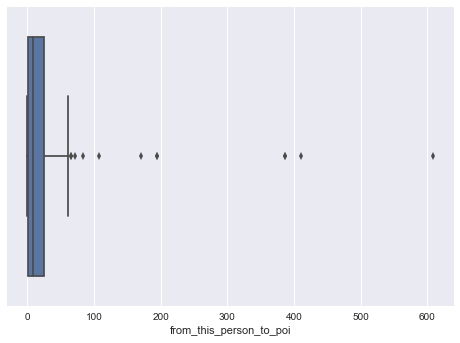

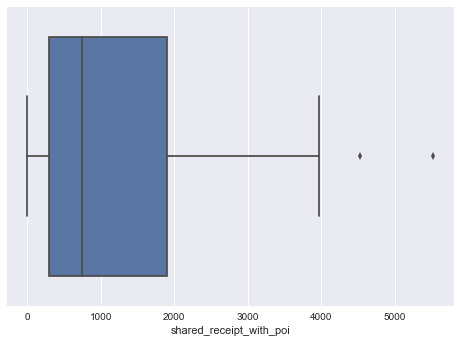

In [20]:
for feat in email_features:
    sns.boxplot(sub_data[feat])
    plt.show()

In [21]:
data.ix[data.from_messages.idxmax(), ['name', 'poi']]

name    Kaminski Wincenty J
poi                   False
Name: 55, dtype: object

Again, just another high-ranking Enron employee, I don't want to remove him. 

### Checking Data Distribution

Might be unecessary

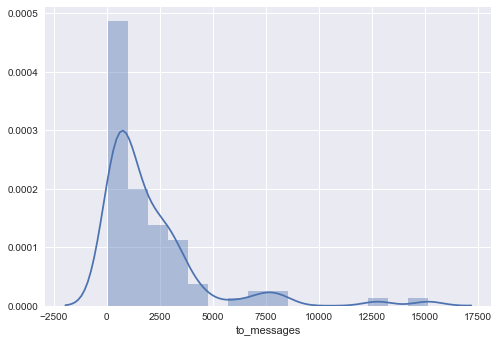

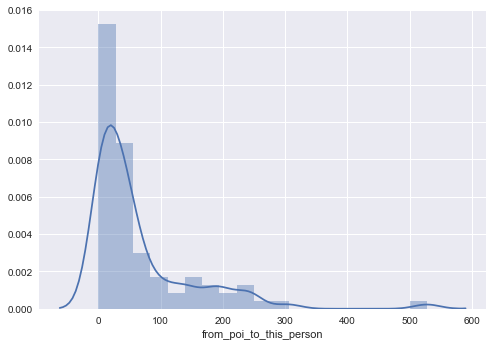

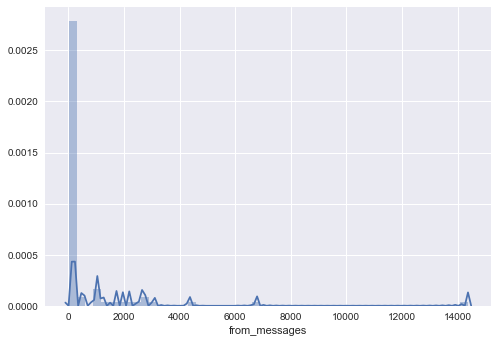

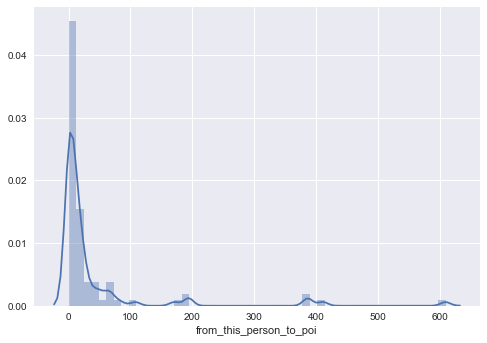

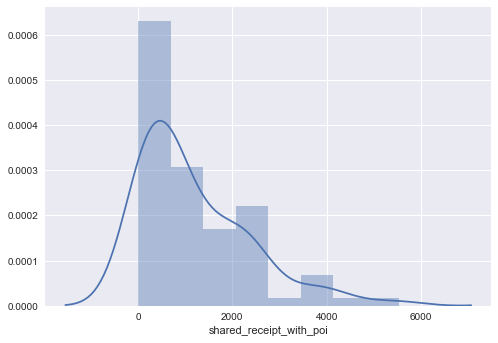

In [22]:
for feat in email_features:
    sns.distplot(sub_data.loc[pd.notnull(sub_data[feat]), feat])
    plt.show()

### Other Outliers

In [25]:
list(data.name)

['Skilling Jeffrey K',
 'Kitchen Louise',
 'Hayslett Roderick J',
 'The Travel Agency In The Park',
 'Westfahl Richard K',
 'Powers William',
 'Olson Cindy K',
 'Gray Rodney',
 'Dimichele Richard G',
 'Wodraska John',
 'Blachman Jeremy M',
 'Muller Mark S',
 'Garland C Kevin',
 'Bannantine James M',
 'Duncan John H',
 'Elliott Steven',
 'Buchanan Harold G',
 'Badum James P',
 'Wasaff George',
 'Kean Steven J',
 'Whaley David A',
 'Moran Michael P',
 'Duran William D',
 'Meyer Jerome J',
 'Horton Stanley C',
 'Buy Richard B',
 'Gold Joseph',
 'Meyer Rockford G',
 'Dodson Keith',
 'Cumberland Michael S',
 'Rieker Paula H',
 'Bowen Jr Raymond M',
 'Mcdonald Rebecca',
 'Metts Mark',
 'Umanoff Adam S',
 'Shelby Rex',
 'Walters Gareth W',
 'Blake Jr. Norman P',
 'Yeager F Scott',
 'Winokur Jr. Herbert S',
 'Hickerson Gary J',
 'Carter Rebecca C',
 'Berberian David',
 'Stabler Frank',
 'Walls Jr Robert H',
 'Fugh John L',
 'Hughes James A',
 'Mcmahon Jeffrey',
 'Pai Lou L',
 'Glisan Jr Ben F'

In [26]:
# "The Travel Agency In The Park" is clearly not a person
data = data[data.name != 'The Travel Agency In The Park']

In [38]:
# All null for relevant features
data[pd.isnull(data[all_features]).all(axis=1)]

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,name,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Lockhart Eugene E,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
data = data[data.index != 95]

### Feature Selection
To avoid excessive noise in my model, I want to limit myself to only predictors that best separate my classes. I used SelectKBest in Sklearn to help narrow down my feature selection.

In [24]:
base_pipeline = [('imputer', Imputer(strategy='median')), 
                 ('selector', SelectKBest(score_func=f_classif, k='all'))
                ]

In [23]:
model = imb_pipeline(base_pipeline)

In [24]:
X, y = data[all_features], data.poi

In [25]:
model.fit(X, y);

In [26]:
scores = pd.Series(model.named_steps['selector'].scores_, index=all_features)
scores = scores.sort_values()

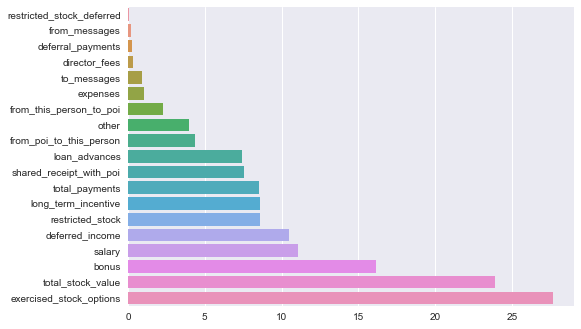

In [28]:
ax = sns.barplot(x=scores.values, y=scores.keys())

It clear for the above plot that certain features are much stronger indicators of poi vs non-poi individuals. Later when optimizing my model, I only fit a subset of these features with the highest F scores. 

#### Creating New Features

I suspect one of the defining characteristics of a POI is that they are more intersted in short term gain gain than the overall health of the company. A good construct to measure this measure this might be the ratio of stock value or bonuses to long term incentive and deferred income. 

In [29]:
data['ex_stock_to_incentive'] = data.exercised_stock_options / data.long_term_incentive
data['bonus_to_deferred_income'] = data.bonus / data.deferred_income
data['ex_stock_to_rest_stock'] = data.exercised_stock_options / data.restricted_stock

In [30]:
my_features = ['ex_stock_to_incentive', 
               'bonus_to_deferred_income',
               'ex_stock_to_rest_stock']

In [31]:
X, y = data[my_features], data.poi
model.fit(X, y);

In [32]:
scores = pd.Series(model.named_steps['selector'].scores_, index=my_features)
scores = scores.sort_values()

In [33]:
scores

ex_stock_to_incentive       0.023276
ex_stock_to_rest_stock      0.055454
bonus_to_deferred_income    6.822330
dtype: float64

None of my new features appear particularly compelling, and once you consider issues of multicollinearity, it seems safer to just ignore them. 